In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Carregamento arquivo de pré-processamento

In [2]:
%run "/content/drive/My Drive/pre_processamento_TCC.ipynb"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
CPU times: user 1min 49s, sys: 11.2 s, total: 2min
Wall time: 2min 5s
Ataque de exploração UDPLag:  Label
BENIGN       3705
UDP-lag    366461
dtype: int64 

Ataque de exploração Syn:  Label
BENIGN        392
Syn       1582289
dtype: int64 

Ataque de exploração LDAP:  Label
BENIGN           1612
DrDoS_LDAP    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
BENIGN              1707
DrDoS_NetBIOS    4093279
dtype: int64
Ataque de exploração UDPLag:  Label
0      3705
1    366461
dtype: int64 

Ataque de exploração Syn:  Label
0        392
1    1582289
dtype: int64 

Ataque de exploração LDAP:  Label
0       1612
1    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
0       1707
1    4093279
dtype: int64


### Bibliotecas


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### Divisão do conjunto em treino e teste


In [4]:
UDPlag

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1,2,0,766.0,0.0,383.0,383.0,383.0,0.0,0.0,0.0,0.0,0.0,766000000.0,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.000000,383.0,383.0,383.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,574.5,383.0,0.0,-2,0,0,0,0,0,0,2,766,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,2,0,778.0,0.0,389.0,389.0,389.0,0.0,0.0,0.0,0.0,0.0,778000000.0,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.000000,389.0,389.0,389.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,583.5,389.0,0.0,-2,0,0,0,0,0,0,2,778,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2,2,0,750.0,0.0,375.0,375.0,375.0,0.0,0.0,0.0,0.0,0.0,375000000.0,1.000000e+06,2.000000,0.000000,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,1.000000e+06,0.000000,375.0,375.0,375.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,562.5,375.0,0.0,-2,0,0,0,0,0,0,2,750,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2,2,0,738.0,0.0,369.0,369.0,369.0,0.0,0.0,0.0,0.0,0.0,369000000.0,1.000000e+06,2.000000,0.000000,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,1.000000e+06,0.000000,369.0,369.0,369.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,553.5,369.0,0.0,-2,0,0,0,0,0,0,2,738,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,2,0,750.0,0.0,375.0,375.0,375.0,0.0,0.0,0.0,0.0,0.0,750000000.0,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.000000,375.0,375.0,375.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,562.5,375.0,0.0,-2,0,0,0,0,0,0,2,750,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370599,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
370600,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,5840,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
370601,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,40,0,0,0,0,

Preparação dos dados treino e teste


In [5]:
X = UDPlag.iloc[:, 0:77]
y = UDPlag.iloc[:,- 1]

70% para treino, 30% para teste

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                    random_state=42)

In [7]:
# Formato dos dados de entrada
print('Formato dos dados de entrada:', x_train.shape)

# Tamanho dos conjuntos
print('Amostras de treino: ', x_train.shape[0])
print('Amostras de teste: ', x_test.shape[0])

Formato dos dados de entrada: (233634, 77)
Amostras de treino:  233634
Amostras de teste:  100129


### Seleção dos Parâmetro
Seleção dos 15 melhores parâmetros.

In [8]:
best_features = SelectKBest(score_func=f_classif, k=15)
fit = best_features.fit(x_train,y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x_train.columns)
# concatenar quadros de dados
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # colunas de saída de nome
print(feature_scores.nlargest(15,'Score'))  # imprima 15 melhores parâmetros

                Feature_Name          Score
47            URG Flag Count  110569.603753
48            CWE Flag Count   50096.792295
11    Bwd Packet Length Mean   33925.850698
53      Avg Bwd Segment Size   33925.850698
9      Bwd Packet Length Max   32796.113276
29             Fwd PSH Flags   29159.350848
44            RST Flag Count   29159.350848
50             Down/Up Ratio   27909.522885
40         Packet Length Std   26857.407173
66   Init_Win_bytes_backward   26760.422368
12     Bwd Packet Length Std   23563.411565
34         Bwd Header Length   23133.283185
8      Fwd Packet Length Std   18141.562396
10     Bwd Packet Length Min   17837.128675
41    Packet Length Variance   15762.971567


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [30 31 32 42 45 49 55 56 57 58 59 60] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [9]:
feature = feature_scores.nlargest(15,'Score')
feature

,Feature_Name,Score
47,URG Flag Count,110569.603753
48,CWE Flag Count,50096.792295
11,Bwd Packet Length Mean,33925.850698
53,Avg Bwd Segment Size,33925.850698
9,Bwd Packet Length Max,32796.113276
29,Fwd PSH Flags,29159.350848
44,RST Flag Count,29159.350848
50,Down/Up Ratio,27909.522885
40,Packet Length Std,26857.407173
66,Init_Win_bytes_backward,26760.422368


Exlusão dos parâmetros que não seram usados no modelo.


In [10]:
netbios.columns

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SY

In [11]:
x_train = x_train.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

x_test = x_test.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

### Normalização dos dados

In [12]:
normalizador = MinMaxScaler()
x_train= normalizador.fit_transform(x_train)
x_test = normalizador.fit_transform(x_test)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

### Formatação do tensor em 3D

In [13]:
x_train= x_train.reshape(-1, 233634, 15)
y_train= y_train.reshape(-1, 233634, 1)
x_test = x_test.reshape(-1, 100129, 15)
y_test = y_test.reshape(-1, 100129, 1)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1, 233634, 15)
(1, 233634, 1)
(1, 100129, 15)
(1, 100129, 1)


### Rede Neural Recorrente (LSTM)

#### Experimento 1

In [15]:
model1 = Sequential()
model1.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

# Camada Final
model1.add(Dense(1, activation='sigmoid'))

# Compile model
model1.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model1.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2501 - accuracy: 0.3533 - auc: 0.4992 - recall: 0.3507 - precision: 0.9870 - root_mean_squared_error: 0.5001 - val_loss: 0.2432 - val_accuracy: 0.9889 - val_auc: 0.4974 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4932
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2433 - accuracy: 0.9890 - auc: 0.4990 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.4932 - val_loss: 0.2371 - val_accuracy: 0.9889 - val_auc: 0.4992 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4869
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2372 - accuracy: 0.9890 - auc: 0.4966 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.4870 - val_loss: 0.2301 - val_accuracy: 0.9889 - val_auc: 0.4980 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4797
Epoch 4/50
1/1 [===============

In [16]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 233634, 20)        2880      
_________________________________________________________________
dropout (Dropout)            (None, 233634, 20)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 233634, 10)        8

In [17]:
checkpointer1 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer1], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01513, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0204 - accuracy: 0.9890 - auc: 0.4995 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1429 - val_loss: 0.0151 - val_accuracy: 0.9889 - val_auc: 0.5010 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1230
Epoch 2/50

Epoch 00002: val_loss improved from 0.01513 to 0.01494, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0201 - accuracy: 0.9890 - auc: 0.5036 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1418 - val_loss: 0.0149 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1222
Epoch 3/50

Epoch 00003: val_loss improved from 0.01494 to 0.01476, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0198 - accuracy: 0.9890 - auc: 0.5087 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1407 - val_loss

In [18]:
scores1 = model1.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores1[0]*100))
print("Acurácia: %.2f%%" % (scores1[1]*100))
print("AUC: %.2f%%" % (scores1[2]*100))
print("Recall: %.2f%%" % (scores1[3]*100))
print("Precision: %.2f%%" % (scores1[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores1[5]*100))

UDPlag
Loss: 1.14%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.68%


#### Experimento 2

In [19]:
model2 = Sequential()
model2.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

# Camada Final
model2.add(Dense(1, activation='sigmoid'))

# Compile model
model2.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model2.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2501 - accuracy: 0.2419 - auc: 0.4997 - recall: 0.2367 - precision: 0.9866 - root_mean_squared_error: 0.5001 - val_loss: 0.2425 - val_accuracy: 0.9889 - val_auc: 0.4971 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4924
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2424 - accuracy: 0.9853 - auc: 0.4964 - recall: 0.9962 - precision: 0.9890 - root_mean_squared_error: 0.4924 - val_loss: 0.2347 - val_accuracy: 0.9889 - val_auc: 0.4975 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4845
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2347 - accuracy: 0.9845 - auc: 0.5020 - recall: 0.9954 - precision: 0.9890 - root_mean_squared_error: 0.4845 - val_loss: 0.2242 - val_accuracy: 0.9889 - val_auc: 0.4957 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4735
Epoch 4/50
1/1 [===============

In [20]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_4 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_6 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 233634, 10)       

In [21]:
checkpointer2 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer2], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.02070, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0298 - accuracy: 0.9889 - auc: 0.5084 - recall: 0.9999 - precision: 0.9890 - root_mean_squared_error: 0.1726 - val_loss: 0.0207 - val_accuracy: 0.9889 - val_auc: 0.5006 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1439
Epoch 2/50

Epoch 00002: val_loss improved from 0.02070 to 0.02024, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0292 - accuracy: 0.9889 - auc: 0.5004 - recall: 0.9999 - precision: 0.9890 - root_mean_squared_error: 0.1710 - val_loss: 0.0202 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1423
Epoch 3/50

Epoch 00003: val_loss improved from 0.02024 to 0.01981, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0287 - accuracy: 0.9889 - auc: 0.4961 - recall: 0.9999 - precision: 0.9890 - root_mean_squared_error: 0.1693 - val_loss

In [22]:
scores2 = model2.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores2[0]*100))
print("Acurácia: %.2f%%" % (scores2[1]*100))
print("AUC: %.2f%%" % (scores2[2]*100))
print("Recall: %.2f%%" % (scores2[3]*100))
print("Precision: %.2f%%" % (scores2[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores2[5]*100))

UDPlag
Loss: 1.21%
Acurácia: 98.89%
AUC: 50.07%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 11.00%


#### Experimento 3

In [23]:
model3 = Sequential()
model3.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

# Camada Final
model3.add(Dense(1, activation='sigmoid'))

# Compile model
model3.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model3.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2505 - accuracy: 0.3176 - auc: 0.5037 - recall: 0.3134 - precision: 0.9892 - root_mean_squared_error: 0.5005 - val_loss: 0.2372 - val_accuracy: 0.9889 - val_auc: 0.5051 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4871
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2373 - accuracy: 0.9890 - auc: 0.5028 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.4871 - val_loss: 0.2242 - val_accuracy: 0.9889 - val_auc: 0.4982 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4735
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2243 - accuracy: 0.9890 - auc: 0.4996 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.4736 - val_loss: 0.2079 - val_accuracy: 0.9889 - val_auc: 0.5044 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4560
Epoch 4/50
1/1 [===============

In [24]:
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_8 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_10 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 233634, 10)       

In [25]:
checkpointer3 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist3 = model3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer3], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01549, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0206 - accuracy: 0.9890 - auc: 0.4961 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1434 - val_loss: 0.0155 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1245
Epoch 2/50

Epoch 00002: val_loss improved from 0.01549 to 0.01530, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0202 - accuracy: 0.9890 - auc: 0.5054 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1422 - val_loss: 0.0153 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1237
Epoch 3/50

Epoch 00003: val_loss improved from 0.01530 to 0.01512, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0201 - accuracy: 0.9890 - auc: 0.4976 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1416 - val_loss

In [26]:
scores3 = model3.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores3[0]*100))
print("Acurácia: %.2f%%" % (scores3[1]*100))
print("AUC: %.2f%%" % (scores3[2]*100))
print("Recall: %.2f%%" % (scores3[3]*100))
print("Precision: %.2f%%" % (scores3[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores3[5]*100))

UDPlag
Loss: 1.15%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.72%


#### Experimento 4

In [27]:
model4 = Sequential()
model4.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

# Camada Final
model4.add(Dense(1, activation='sigmoid'))

# Compile model
model4.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model4.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2497 - accuracy: 0.7372 - auc: 0.4945 - recall: 0.7423 - precision: 0.9893 - root_mean_squared_error: 0.4997 - val_loss: 0.2361 - val_accuracy: 0.9889 - val_auc: 0.5004 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4859
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2364 - accuracy: 0.9885 - auc: 0.4938 - recall: 0.9995 - precision: 0.9890 - root_mean_squared_error: 0.4862 - val_loss: 0.2215 - val_accuracy: 0.9889 - val_auc: 0.4952 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4706
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2219 - accuracy: 0.9886 - auc: 0.5000 - recall: 0.9996 - precision: 0.9890 - root_mean_squared_error: 0.4710 - val_loss: 0.2029 - val_accuracy: 0.9889 - val_auc: 0.4932 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4505
Epoch 4/50
1/1 [===============

In [28]:
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_12 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_14 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 233634, 10)       

In [29]:
checkpointer4 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist4 = model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer4], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01266, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0158 - accuracy: 0.9890 - auc: 0.5040 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1259 - val_loss: 0.0127 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1125
Epoch 2/50

Epoch 00002: val_loss improved from 0.01266 to 0.01257, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0157 - accuracy: 0.9890 - auc: 0.4995 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1254 - val_loss: 0.0126 - val_accuracy: 0.9889 - val_auc: 0.5003 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1121
Epoch 3/50

Epoch 00003: val_loss improved from 0.01257 to 0.01250, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0156 - accuracy: 0.9890 - auc: 0.4934 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1249 - val_loss

In [30]:
scores4 = model4.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores4[0]*100))
print("Acurácia: %.2f%%" % (scores4[1]*100))
print("AUC: %.2f%%" % (scores4[2]*100))
print("Recall: %.2f%%" % (scores4[3]*100))
print("Precision: %.2f%%" % (scores4[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores4[5]*100))

UDPlag
Loss: 1.11%
Acurácia: 98.89%
AUC: 50.07%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.53%


#### Experimento 5

In [31]:
model5 = Sequential()
model5.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

# Camada Final
model5.add(Dense(1, activation='sigmoid'))

# Compile model
model5.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model5.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2500 - accuracy: 0.3285 - auc: 0.5002 - recall: 0.3243 - precision: 0.9902 - root_mean_squared_error: 0.5000 - val_loss: 0.2432 - val_accuracy: 0.9889 - val_auc: 0.4988 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4931
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2432 - accuracy: 0.9880 - auc: 0.5100 - recall: 0.9990 - precision: 0.9890 - root_mean_squared_error: 0.4931 - val_loss: 0.2367 - val_accuracy: 0.9889 - val_auc: 0.4988 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4865
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2367 - accuracy: 0.9885 - auc: 0.4985 - recall: 0.9995 - precision: 0.9890 - root_mean_squared_error: 0.4865 - val_loss: 0.2292 - val_accuracy: 0.9889 - val_auc: 0.4971 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4788
Epoch 4/50
1/1 [===============

In [32]:
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_16 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_17 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_18 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 233634, 10)       

In [33]:
checkpointer5 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist5 = model5.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer5], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01329, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0175 - accuracy: 0.9890 - auc: 0.5053 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1324 - val_loss: 0.0133 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1153
Epoch 2/50

Epoch 00002: val_loss improved from 0.01329 to 0.01317, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0173 - accuracy: 0.9890 - auc: 0.5058 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1315 - val_loss: 0.0132 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1147
Epoch 3/50

Epoch 00003: val_loss improved from 0.01317 to 0.01305, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0172 - accuracy: 0.9890 - auc: 0.4949 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1310 - val_loss

In [34]:
scores5 = model5.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores5[0]*100))
print("Acurácia: %.2f%%" % (scores5[1]*100))
print("AUC: %.2f%%" % (scores5[2]*100))
print("Recall: %.2f%%" % (scores5[3]*100))
print("Precision: %.2f%%" % (scores5[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores5[5]*100))

UDPlag
Loss: 1.12%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.57%


#### Experimento 6

In [35]:
model6 = Sequential()
model6.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

# Camada Final
model6.add(Dense(1, activation='sigmoid'))

# Compile model
model6.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model6.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2500 - accuracy: 0.4013 - auc: 0.5006 - recall: 0.3997 - precision: 0.9874 - root_mean_squared_error: 0.5000 - val_loss: 0.2414 - val_accuracy: 0.9889 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4914
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2415 - accuracy: 0.9890 - auc: 0.4943 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.4914 - val_loss: 0.2332 - val_accuracy: 0.9889 - val_auc: 0.4954 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4829
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2332 - accuracy: 0.9890 - auc: 0.5074 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.4829 - val_loss: 0.2231 - val_accuracy: 0.9889 - val_auc: 0.5029 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4724
Epoch 4/50
1/1 [===============

In [36]:
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_20 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_21 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_22 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 233634, 10)       

In [37]:
checkpointer6 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist6 = model6.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer6], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01164, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0138 - accuracy: 0.9890 - auc: 0.5013 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1176 - val_loss: 0.0116 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1079
Epoch 2/50

Epoch 00002: val_loss improved from 0.01164 to 0.01160, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0138 - accuracy: 0.9890 - auc: 0.4918 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1174 - val_loss: 0.0116 - val_accuracy: 0.9889 - val_auc: 0.5010 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1077
Epoch 3/50

Epoch 00003: val_loss improved from 0.01160 to 0.01155, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0136 - accuracy: 0.9890 - auc: 0.4947 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1168 - val_loss

In [38]:
scores6 = model6.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores6[0]*100))
print("Acurácia: %.2f%%" % (scores6[1]*100))
print("AUC: %.2f%%" % (scores6[2]*100))
print("Recall: %.2f%%" % (scores6[3]*100))
print("Precision: %.2f%%" % (scores6[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores6[5]*100))

UDPlag
Loss: 1.10%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.50%


#### Experimento 7

In [39]:
model7 = Sequential()
model7.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

# Camada Final
model7.add(Dense(1, activation='sigmoid'))

# Compile model
model7.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model7.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2501 - accuracy: 0.2891 - auc: 0.4996 - recall: 0.2853 - precision: 0.9858 - root_mean_squared_error: 0.5001 - val_loss: 0.2444 - val_accuracy: 0.9889 - val_auc: 0.5015 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4944
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2444 - accuracy: 0.9845 - auc: 0.4952 - recall: 0.9954 - precision: 0.9890 - root_mean_squared_error: 0.4943 - val_loss: 0.2392 - val_accuracy: 0.9889 - val_auc: 0.5033 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4890
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2391 - accuracy: 0.9846 - auc: 0.5045 - recall: 0.9955 - precision: 0.9890 - root_mean_squared_error: 0.4890 - val_loss: 0.2327 - val_accuracy: 0.9889 - val_auc: 0.4909 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4824
Epoch 4/50
1/1 [===============

In [40]:
print(model7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_24 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_25 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_26 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 233634, 10)       

In [41]:
checkpointer7 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist7 = model7.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer7], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01533, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0218 - accuracy: 0.9890 - auc: 0.4849 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1475 - val_loss: 0.0153 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1238
Epoch 2/50

Epoch 00002: val_loss improved from 0.01533 to 0.01513, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0214 - accuracy: 0.9890 - auc: 0.5037 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1463 - val_loss: 0.0151 - val_accuracy: 0.9889 - val_auc: 0.5010 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1230
Epoch 3/50

Epoch 00003: val_loss improved from 0.01513 to 0.01494, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0211 - accuracy: 0.9890 - auc: 0.4981 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1452 - val_loss

In [42]:
scores7 = model7.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores7[0]*100))
print("Acurácia: %.2f%%" % (scores7[1]*100))
print("AUC: %.2f%%" % (scores7[2]*100))
print("Recall: %.2f%%" % (scores7[3]*100))
print("Precision: %.2f%%" % (scores7[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores7[5]*100))

UDPlag
Loss: 1.16%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.75%


#### Experimento 8

In [43]:
model8 = Sequential()
model8.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

# Camada Final
model8.add(Dense(1, activation='sigmoid'))

# Compile model
model8.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model8.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2501 - accuracy: 0.6786 - auc: 0.4964 - recall: 0.6820 - precision: 0.9899 - root_mean_squared_error: 0.5001 - val_loss: 0.2365 - val_accuracy: 0.9889 - val_auc: 0.4951 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4863
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2366 - accuracy: 0.9884 - auc: 0.4983 - recall: 0.9994 - precision: 0.9890 - root_mean_squared_error: 0.4864 - val_loss: 0.2228 - val_accuracy: 0.9889 - val_auc: 0.4971 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4721
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2232 - accuracy: 0.9885 - auc: 0.4964 - recall: 0.9995 - precision: 0.9890 - root_mean_squared_error: 0.4724 - val_loss: 0.2050 - val_accuracy: 0.9889 - val_auc: 0.4973 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4527
Epoch 4/50
1/1 [===============

In [44]:
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_28 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_30 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 233634, 10)       

In [45]:
checkpointer8 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist8 = model8.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer8], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01513, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0213 - accuracy: 0.9889 - auc: 0.4885 - recall: 0.9999 - precision: 0.9890 - root_mean_squared_error: 0.1461 - val_loss: 0.0151 - val_accuracy: 0.9889 - val_auc: 0.5010 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1230
Epoch 2/50

Epoch 00002: val_loss improved from 0.01513 to 0.01497, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0211 - accuracy: 0.9888 - auc: 0.5052 - recall: 0.9998 - precision: 0.9890 - root_mean_squared_error: 0.1451 - val_loss: 0.0150 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1223
Epoch 3/50

Epoch 00003: val_loss improved from 0.01497 to 0.01481, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0208 - accuracy: 0.9888 - auc: 0.5071 - recall: 0.9998 - precision: 0.9890 - root_mean_squared_error: 0.1442 - val_loss

In [46]:
scores8 = model8.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores8[0]*100))
print("Acurácia: %.2f%%" % (scores8[1]*100))
print("AUC: %.2f%%" % (scores8[2]*100))
print("Recall: %.2f%%" % (scores8[3]*100))
print("Precision: %.2f%%" % (scores8[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores8[5]*100))

UDPlag
Loss: 1.15%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.71%


#### Experimento 9

In [47]:
model9 = Sequential()
model9.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

# Camada Final
model9.add(Dense(1, activation='sigmoid'))

# Compile model
model9.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model9.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2498 - accuracy: 0.7091 - auc: 0.5003 - recall: 0.7143 - precision: 0.9884 - root_mean_squared_error: 0.4998 - val_loss: 0.2390 - val_accuracy: 0.9889 - val_auc: 0.5041 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4889
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2392 - accuracy: 0.9888 - auc: 0.4948 - recall: 0.9998 - precision: 0.9890 - root_mean_squared_error: 0.4890 - val_loss: 0.2268 - val_accuracy: 0.9889 - val_auc: 0.5009 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4762
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2271 - accuracy: 0.9887 - auc: 0.5049 - recall: 0.9997 - precision: 0.9890 - root_mean_squared_error: 0.4765 - val_loss: 0.2100 - val_accuracy: 0.9889 - val_auc: 0.4858 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4583
Epoch 4/50
1/1 [===============

In [48]:
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_28 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_30 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 233634, 10)       

In [49]:
checkpointer9 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist9 = model9.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer9], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01333, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0181 - accuracy: 0.9890 - auc: 0.4905 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1347 - val_loss: 0.0133 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1155
Epoch 2/50

Epoch 00002: val_loss improved from 0.01333 to 0.01321, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0179 - accuracy: 0.9890 - auc: 0.5026 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1336 - val_loss: 0.0132 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1149
Epoch 3/50

Epoch 00003: val_loss improved from 0.01321 to 0.01310, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0177 - accuracy: 0.9890 - auc: 0.4928 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1332 - val_loss

In [50]:
scores9 = model9.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores9[0]*100))
print("Acurácia: %.2f%%" % (scores9[1]*100))
print("AUC: %.2f%%" % (scores9[2]*100))
print("Recall: %.2f%%" % (scores9[3]*100))
print("Precision: %.2f%%" % (scores9[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores9[5]*100))

UDPlag
Loss: 1.12%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.59%


#### Experimento 10

In [51]:
model10 = Sequential()
model10.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

# Camada Final
model10.add(Dense(1, activation='sigmoid'))

# Compile model
model10.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model10.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2501 - accuracy: 0.4134 - auc: 0.5029 - recall: 0.4118 - precision: 0.9880 - root_mean_squared_error: 0.5001 - val_loss: 0.2391 - val_accuracy: 0.9889 - val_auc: 0.5008 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4889
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2391 - accuracy: 0.9883 - auc: 0.4942 - recall: 0.9993 - precision: 0.9890 - root_mean_squared_error: 0.4890 - val_loss: 0.2276 - val_accuracy: 0.9889 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4770
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2276 - accuracy: 0.9886 - auc: 0.5010 - recall: 0.9996 - precision: 0.9890 - root_mean_squared_error: 0.4771 - val_loss: 0.2131 - val_accuracy: 0.9889 - val_auc: 0.4988 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.4617
Epoch 4/50
1/1 [===============

In [52]:
print(model10.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_36 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_37 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_38 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 233634, 10)       

In [53]:
checkpointer10 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist10 = model10.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer10], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01165, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0141 - accuracy: 0.9890 - auc: 0.4931 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1189 - val_loss: 0.0116 - val_accuracy: 0.9889 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1079
Epoch 2/50

Epoch 00002: val_loss improved from 0.01165 to 0.01160, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0140 - accuracy: 0.9890 - auc: 0.5035 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1185 - val_loss: 0.0116 - val_accuracy: 0.9889 - val_auc: 0.5010 - val_recall: 1.0000 - val_precision: 0.9889 - val_root_mean_squared_error: 0.1077
Epoch 3/50

Epoch 00003: val_loss improved from 0.01160 to 0.01155, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0139 - accuracy: 0.9890 - auc: 0.4954 - recall: 1.0000 - precision: 0.9890 - root_mean_squared_error: 0.1180 - val_loss

In [54]:
scores10 = model10.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores10[0]*100))
print("Acurácia: %.2f%%" % (scores10[1]*100))
print("AUC: %.2f%%" % (scores10[2]*100))
print("Recall: %.2f%%" % (scores10[3]*100))
print("Precision: %.2f%%" % (scores10[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores10[5]*100))

UDPlag
Loss: 1.10%
Acurácia: 98.89%
AUC: 50.03%
Recall: 100.00%
Precision: 98.89%
RootMeanSquaredError: 10.50%


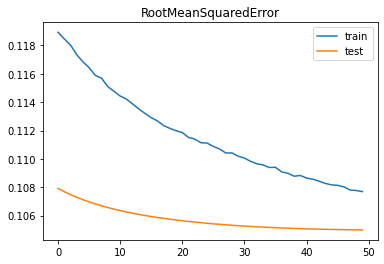

In [55]:
plt.title('RootMeanSquaredError')
plt.plot(hist10.history['root_mean_squared_error'], label='train')
plt.plot(hist10.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show();